# Biomedical Named Entity Recognition

This notebook implements the Random Forest approach for Named Entity Recognition (NER) on the GENIA corpus, with **advanced features** from research papers:

## Advanced Features Implemented:

### 1. **Word Cache** 
Tracks whether a word has appeared previously in the document, helping identify recurring entities.

### 2. **HMM States**
Unsupervised Hidden Markov Model trained to generate features for rare words, improving handling of low-frequency biomedical terms.

### 3. **Viterbi Decoding**
Dynamic programming algorithm that enforces valid BIO tag sequences:
- Prevents invalid transitions (e.g., O → I-Protein without B-Protein)
- Ensures coherent entity boundaries
- Improves overall sequence consistency

## Workflow:
1. Download GENIA corpus
2. Parse XML and extract BIO tags
3. Train HMM on corpus vocabulary
4. Extract features (window, POS, cache, HMM states)
5. Train  classifiers
6. Evaluate with and without Viterbi decoding
7. Compare performance improvements

In [ ]:
# Imports
import urllib.request
import zipfile
import os
import shutil
import xml.etree.ElementTree as ET
import nltk
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download necessary NLTK data for tokenization and POS tagging
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Import additional models for comparison
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import joblib
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rahli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rahli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\rahli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
def download_from_github():
    """Télécharge le corpus GENIA directement depuis GitHub"""

    print("Téléchargement du corpus GENIA depuis GitHub...")
    print("="*60)

    # 1. Define repository URL and destination paths
    repo_url = "https://github.com/openbiocorpora/genia-term/archive/refs/heads/master.zip"
    os.makedirs("genia_data", exist_ok=True)
    zip_path = "genia_data/genia-term-master.zip"

    try:
        # 2. Download the zip file
        print("\n[1/3] Téléchargement...")
        urllib.request.urlretrieve(repo_url, zip_path)
        print(f"[OK] Téléchargé: {zip_path}")

        # 3. Extract contents
        print("\n[2/3] Extraction...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("genia_data")
        print("[OK] Fichiers extraits")

        # 4. List extracted files to verify
        print("\n[3/3] Fichiers disponibles:")
        extracted_path = "genia_data/genia-term-master"

        for root, dirs, files in os.walk(extracted_path):
            for file in files:
                if file.endswith(('.xml', '.txt', '.a1', '.a2')):
                    file_path = os.path.join(root, file)
                    rel_path = os.path.relpath(file_path, "genia_data")
                    size = os.path.getsize(file_path) / 1024  # KB
                    print(f"  - {rel_path} ({size:.1f} KB)")

        print("\n" + "="*60)
        print("[OK] SUCCÈS! Corpus GENIA téléchargé")
        print(f"[OK] Dossier: {extracted_path}")
        print("="*60)

        return extracted_path

    except Exception as e:
        print(f"[ERROR] Erreur: {e}")
        return None

if __name__ == "__main__":
    download_from_github()

Téléchargement du corpus GENIA depuis GitHub...

[1/3] Téléchargement...
[ERROR] Erreur: <urlopen error [Errno 11001] getaddrinfo failed>
[ERROR] Erreur: <urlopen error [Errno 11001] getaddrinfo failed>


In [ ]:
def parse_genia_xml(xml_path):
    """
    Parses GENIA XML to extract words and BIO tags.
    Ignores nested entities for simplicity (keeps the outermost).
    """
    # Parse the XML tree
    tree = ET.parse(xml_path)
    root = tree.getroot()

    all_sentences = []

    # Iterate over abstracts (articles)
    for article in root.findall('.//article'):
        for sent_tag in article.findall('.//sentence'):
            tokens = []
            labels = []

            # Helper to tokenize text and assign BIO labels
            def process_text(text, label):
                if not text: return
                words = nltk.word_tokenize(text)
                if not words: return

                for i, w in enumerate(words):
                    tokens.append(w)
                    if label == 'O':
                        labels.append('O')
                    else:
                        # BIO encoding: First word is B-, rest are I-
                        prefix = 'B-' if i == 0 else 'I-'
                        labels.append(f"{prefix}{label}")

            # Process text at start of sentence (before any entity)
            if sent_tag.text:
                process_text(sent_tag.text, 'O')

            # Process child elements (entities)
            for child in sent_tag:
                if child.tag == 'cons':
                    # Extract the semantic class (e.g., G#protein)
                    raw_class = child.get('sem', 'O')
                    # Clean the class name (e.g., "G#protein" -> "protein")
                    entity_class = raw_class.split('#')[-1] if '#' in raw_class else raw_class

                    # Process the text inside the <cons> tag
                    if child.text:
                        process_text(child.text, entity_class)

                # Process text appearing *after* this tag but before the next
                if child.tail:
                    process_text(child.tail, 'O')

            if tokens:
                all_sentences.append(list(zip(tokens, labels)))

    return all_sentences

# Run the parser
# Note: Adjust the path if running locally or if the download path is different
xml_file_path = "genia_data/genia-term-master/original-data/GENIAcorpus3.02.xml"

try:
    print("Parsing XML... this may take a moment.")
    sentences = parse_genia_xml(xml_file_path)
    print(f"[OK] Successfully parsed {len(sentences)} sentences.")
    print("Sample:", sentences[0])
except FileNotFoundError:
    print(f"[ERROR] Could not find file at {xml_file_path}. Check the 'genia_data' folder.")

Parsing XML... this may take a moment.
[OK] Successfully parsed 18546 sentences.
Sample: [('and', 'O'), ('through', 'O'), ('CD28', 'B-protein_molecule'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein_molecule'), ('.', 'O')]
[OK] Successfully parsed 18546 sentences.
Sample: [('and', 'O'), ('through', 'O'), ('CD28', 'B-protein_molecule'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein_molecule'), ('.', 'O')]


In [25]:
def sentence_to_features(sentence, window=2, word_cache=None, hmm=None):
    """
    Converts a sentence (list of word/tag tuples) into a list of feature dicts.
    Implements the sliding window context and suffix/prefix features.
    
    NEW: Adds word cache and HMM state features.
    """
    doc_features = []

    # Extract just the words for POS tagging
    words = [w for w, t in sentence]

    # NLTK pos_tag automatically uses the downloaded tagger
    pos_tags = nltk.pos_tag(words)

    for i in range(len(sentence)):
        word = words[i]
        
        # 1. Base Features (Current Word)
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'pos': pos_tags[i][1],          # Current POS
            'prefix-2': word[:2],           # Prefix features
            'prefix-3': word[:3],
            'suffix-2': word[-2:],          # Suffix features
            'suffix-3': word[-3:],
        }

        # 2. Sliding Window Context (Previous and Next words)
        for w in range(1, window + 1):
            # Previous words (History)
            if i - w >= 0:
                features[f'-{w}:word.lower()'] = words[i-w].lower()
                features[f'-{w}:pos'] = pos_tags[i-w][1]
            else:
                features[f'-{w}:word.lower()'] = 'BOS' # Beginning of Sentence

            # Next words (Future)
            if i + w < len(words):
                features[f'+{w}:word.lower()'] = words[i+w].lower()
                features[f'+{w}:pos'] = pos_tags[i+w][1]
            else:
                features[f'+{w}:word.lower()'] = 'EOS' # End of Sentence

        # 3. ADVANCED: Word Cache Feature
        if word_cache is not None:
            features['in_cache'] = word_cache.contains(word)
            # Add current word to cache for future lookups
            word_cache.add(word)
        
        # 4. ADVANCED: HMM State Feature
        if hmm is not None:
            features['hmm_state'] = hmm.get_state(word)
            # Also add HMM states for context words
            if i - 1 >= 0:
                features['hmm_state-1'] = hmm.get_state(words[i-1])
            if i + 1 < len(words):
                features['hmm_state+1'] = hmm.get_state(words[i+1])

        doc_features.append(features)

    return doc_features

def sentence_to_labels(sentence):
    """
    Extracts labels and applies the 'Class Splitting' technique.
    Splits 'O' into 'O-POS' (e.g., O-NN, O-VB).
    """
    words = [w for w, t in sentence]
    pos_tags = nltk.pos_tag(words)

    labels = []
    for i, (word, label) in enumerate(sentence):
        # The Paper's Strategy: Split 'O' based on POS tag
        if label == 'O':
            # e.g., if word is "the" (DT), label becomes "O-DT"
            current_pos = pos_tags[i][1]
            labels.append(f"O-{current_pos}")
        else:
            labels.append(label)
    return labels

print("[OK] Feature extraction functions defined")

[OK] Feature extraction functions defined


In [26]:
# Advanced Feature 1: Word Cache
# Tracks words seen previously in the document
class WordCache:
    """
    Implements the word cache feature from the paper.
    Tracks if a word has appeared previously in the text.
    """
    def __init__(self):
        self.cache = set()
    
    def add(self, word):
        """Add word to cache"""
        self.cache.add(word.lower())
    
    def contains(self, word):
        """Check if word is in cache"""
        return word.lower() in self.cache
    
    def reset(self):
        """Reset cache for new document"""
        self.cache.clear()

print("[OK] Word Cache class defined")

[OK] Word Cache class defined


In [27]:
# Advanced Feature 2: HMM States for Rare Words
from collections import defaultdict
import numpy as np

class UnsupervisedHMM:
    """
    Implements unsupervised HMM to generate features for rare words.
    Uses a simple frequency-based approach to cluster words into hidden states.
    """
    def __init__(self, n_states=10):
        self.n_states = n_states
        self.word_to_state = {}
        self.state_transitions = None
        
    def fit(self, sentences, min_freq=5):
        """
        Train HMM on sentences.
        Words appearing less than min_freq times get special handling.
        """
        print(f"Training HMM with {self.n_states} states...")
        
        # Count word frequencies
        word_freq = defaultdict(int)
        all_words = []
        
        for sent in sentences:
            for word, _ in sent:
                word_lower = word.lower()
                word_freq[word_lower] += 1
                all_words.append(word_lower)
        
        # Separate frequent and rare words
        frequent_words = {w for w, f in word_freq.items() if f >= min_freq}
        rare_words = {w for w, f in word_freq.items() if f < min_freq}
        
        print(f"  - Frequent words: {len(frequent_words)}")
        print(f"  - Rare words: {len(rare_words)}")
        
        # Assign states based on frequency buckets
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        
        # Distribute words across states
        words_per_state = len(sorted_words) // self.n_states + 1
        
        for idx, (word, freq) in enumerate(sorted_words):
            state_id = min(idx // words_per_state, self.n_states - 1)
            self.word_to_state[word] = state_id
        
        # Rare words get a special state (state 0)
        for word in rare_words:
            self.word_to_state[word] = 0
        
        print(f"[OK] HMM trained with {len(self.word_to_state)} words mapped to {self.n_states} states")
        
        return self
    
    def get_state(self, word):
        """Get HMM state for a word"""
        word_lower = word.lower()
        return self.word_to_state.get(word_lower, 0)  # Default to state 0 (rare)

# Initialize HMM
hmm = UnsupervisedHMM(n_states=10)
print("[OK] HMM class defined")

[OK] HMM class defined


In [28]:
# --- Execution: Train HMM and Extract Features ---
print("Training HMM on corpus...")
# 1. Train HMM on all sentences
hmm.fit(sentences)

print("\nExtracting features with word cache and HMM states...")

X_features = []
y_labels = []

# 2. Initialize word cache for the entire corpus
word_cache = WordCache()

# 3. Process a subset of sentences (e.g., first 5000) for speed
# If you are confident in your RAM, you can increase this number
for sent in sentences[:5000]:
    X_features.extend(sentence_to_features(sent, word_cache=word_cache, hmm=hmm))
    y_labels.extend(sentence_to_labels(sent))

print(f"Total words extracted: {len(X_features)}")
print(f"Sample features: {X_features[0]}")

Training HMM on corpus...
Training HMM with 10 states...
  - Frequent words: 5296
  - Rare words: 12964
[OK] HMM trained with 18260 words mapped to 10 states

Extracting features with word cache and HMM states...
Total words extracted: 118845
Sample features: {'bias': 1.0, 'word.lower()': 'and', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'CC', 'prefix-2': 'an', 'prefix-3': 'and', 'suffix-2': 'nd', 'suffix-3': 'and', '-1:word.lower()': 'BOS', '+1:word.lower()': 'through', '+1:pos': 'IN', '-2:word.lower()': 'BOS', '+2:word.lower()': 'cd28', '+2:pos': 'NNP', 'in_cache': False, 'hmm_state': 0, 'hmm_state+1': 0}
Total words extracted: 118845
Sample features: {'bias': 1.0, 'word.lower()': 'and', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'CC', 'prefix-2': 'an', 'prefix-3': 'and', 'suffix-2': 'nd', 'suffix-3': 'and', '-1:word.lower()': 'BOS', '+1:word.lower()': 'through', '+1:pos': 'IN', '-2:word.lower()': 'BOS', '+

In [29]:
# --- Training the Random Forest ---
print("Vectorizing and Training...")

# 1. Vectorize features (convert dictionaries to sparse matrix)
vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(X_features)
y = y_labels

# 2. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Random Forest Classifier
# n_estimators=50: number of trees
# n_jobs=-1: use all available CPU cores
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# 4. Predict & Evaluate
print("Evaluating...")
y_pred = rf.predict(X_test)

# Get unique labels from the test set to avoid warnings
labels_in_test = sorted(list(set(y_test)))

report = classification_report(y_test, y_pred, labels=labels_in_test)

print("\n--- Performance Report ---")
print(report)

Vectorizing and Training...
Evaluating...
Evaluating...

--- Performance Report ---
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.60      0.45      0.52       321
     B-DNA_family_or_group       0.50      0.19      0.28        63
            B-DNA_molecule       0.75      0.12      0.21        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       1.00      0.12      0.21        17
            B-RNA_molecule       1.00      0.44      0.61        16
      B-amino_acid_monomer       0.83      0.18      0.29        28
                    B-atom       0.67      0.22      0.33        18
               B-body_part       1.00      0.11      0.20        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.88      0.58      0.70        38
               B-cell_line     

Vectorizing and Training...
Evaluating...
Evaluating...

--- Performance Report ---
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.60      0.45      0.52       321
     B-DNA_family_or_group       0.50      0.19      0.28        63
            B-DNA_molecule       0.75      0.12      0.21        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       1.00      0.12      0.21        17
            B-RNA_molecule       1.00      0.44      0.61        16
      B-amino_acid_monomer       0.83      0.18      0.29        28
                    B-atom       0.67      0.22      0.33        18
               B-body_part       1.00      0.11      0.20        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.88      0.58      0.70        38
               B-cell_line     

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [30]:
# Advanced Feature 3: Viterbi Decoding
# Ensures valid BIO tag sequences

class ViterbiDecoder:
    """
    Implements Viterbi decoding for sequence labeling.
    Ensures valid BIO tag transitions (e.g., can't jump from O to I-Protein).
    """
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
        self.classes = model.classes_
        
        # Build transition constraints
        self.build_transition_matrix()
    
    def build_transition_matrix(self):
        """
        Build transition probability matrix based on BIO constraints.
        Invalid transitions get very low probability.
        """
        n_classes = len(self.classes)
        self.transition_matrix = np.ones((n_classes, n_classes))
        
        # Map class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Define BIO transition rules
        for i, prev_tag in enumerate(self.classes):
            for j, curr_tag in enumerate(self.classes):
                if not self.is_valid_transition(prev_tag, curr_tag):
                    self.transition_matrix[i, j] = 1e-10  # Very low probability
        
        print(f"[OK] Transition matrix built for {n_classes} classes")
    
    def is_valid_transition(self, prev_tag, curr_tag):
        """
        Check if transition from prev_tag to curr_tag is valid in BIO scheme.
        
        Rules:
        - O can transition to O, B-*
        - B-X can transition to I-X, O, B-*
        - I-X can transition to I-X, O, B-*
        - Can't go from O to I-* (must have B-* first)
        - Can't go from B-X to I-Y where X != Y
        """
        # Handle O-POS tags (simplified O)
        if prev_tag.startswith('O-'):
            prev_tag = 'O'
        if curr_tag.startswith('O-'):
            curr_tag = 'O'
        
        # O can go anywhere except I-* without B-*
        if prev_tag == 'O':
            if curr_tag.startswith('I-'):
                return False  # Can't jump to I-* from O
            return True
        
        # B-X can go to I-X, O, or any B-*
        if prev_tag.startswith('B-'):
            entity_type = prev_tag[2:]  # Extract entity type
            if curr_tag.startswith('I-'):
                curr_entity = curr_tag[2:]
                return entity_type == curr_entity  # I-* must match B-*
            return True
        
        # I-X can go to I-X, O, or any B-*
        if prev_tag.startswith('I-'):
            entity_type = prev_tag[2:]
            if curr_tag.startswith('I-'):
                curr_entity = curr_tag[2:]
                return entity_type == curr_entity  # I-* must continue same entity
            return True
        
        return True
    
    def decode(self, sentence_features):
        """
        Perform Viterbi decoding on a sequence.
        Returns the most probable valid tag sequence.
        """
        n_words = len(sentence_features)
        n_classes = len(self.classes)
        
        # Get emission probabilities from Random Forest
        X = self.vectorizer.transform(sentence_features)
        emission_probs = self.model.predict_proba(X)
        
        # Initialize Viterbi matrices
        viterbi = np.zeros((n_words, n_classes))
        backpointer = np.zeros((n_words, n_classes), dtype=int)
        
        # Initialize first word
        viterbi[0] = np.log(emission_probs[0] + 1e-10)
        
        # Forward pass
        for t in range(1, n_words):
            for j in range(n_classes):
                # For each current state j, find best previous state i
                trans_probs = np.log(self.transition_matrix[:, j] + 1e-10)
                scores = viterbi[t-1] + trans_probs + np.log(emission_probs[t, j] + 1e-10)
                
                best_prev = np.argmax(scores)
                viterbi[t, j] = scores[best_prev]
                backpointer[t, j] = best_prev
        
        # Backward pass: trace best path
        best_path = np.zeros(n_words, dtype=int)
        best_path[-1] = np.argmax(viterbi[-1])
        
        for t in range(n_words - 2, -1, -1):
            best_path[t] = backpointer[t + 1, best_path[t + 1]]
        
        # Convert indices to labels
        predicted_labels = [self.classes[idx] for idx in best_path]
        
        return predicted_labels

print("[OK] Viterbi Decoder class defined")

[OK] Viterbi Decoder class defined


In [ ]:
# Evaluate with Viterbi Decoding
print("="*60)
print("Evaluating with Viterbi Decoding...")
print("="*60)

# Initialize Viterbi decoder
viterbi_decoder = ViterbiDecoder(rf, vectorizer)

# For evaluation, we need to decode sentence by sentence
# First, reconstruct which test samples belong to which sentences
print("\nRunning Viterbi decoding on test set...")
print("(This may take a moment for large datasets)")

# Decode a sample of sentences for comparison
n_sample_sentences = 100  # Sample size for speed
test_sentences_sample = sentences[4000:4000+n_sample_sentences]

y_viterbi_all = []
y_true_viterbi = []

for sent in test_sentences_sample:
    # Extract features
    word_cache_temp = WordCache()
    sent_features = sentence_to_features(sent, word_cache=word_cache_temp, hmm=hmm)
    sent_labels = sentence_to_labels(sent)
    
    # Viterbi decode
    viterbi_predictions = viterbi_decoder.decode(sent_features)
    
    y_viterbi_all.extend(viterbi_predictions)
    y_true_viterbi.extend(sent_labels)

print(f"\n[OK] Decoded {len(test_sentences_sample)} sentences")
print(f"[OK] Total tokens: {len(y_viterbi_all)}")

Evaluating with Viterbi Decoding...
[OK] Transition matrix built for 113 classes

Running Viterbi decoding on test set...
(This may take a moment for large datasets)

Running Viterbi decoding on test set...
(This may take a moment for large datasets)

[OK] Decoded 100 sentences
[OK] Total tokens: 2321

[OK] Decoded 100 sentences
[OK] Total tokens: 2321


In [32]:
def simplify_label(label):
    """
    Maps fine-grained classes back to high-level categories for evaluation.
    Matches the grouping style of Table 4 in the paper.
    """
    if label.startswith('O-'):
        return 'O'

    # Remove the BIO prefix (B- / I-) to see the main category
    # GENIA has fine-grained tags like 'protein_molecule', 'protein_family'
    # We group them into 'Protein', 'DNA', 'RNA', etc.

    # Extract the base name (remove B- or I-)
    parts = label.split('-')
    if len(parts) < 2: return 'O' # Safety check

    category = parts[1] # e.g., 'protein_molecule'

    # Grouping rules based on GENIA ontology
    if 'protein' in category:
        return 'Protein'
    elif 'DNA' in category:
        return 'DNA'
    elif 'RNA' in category:
        return 'RNA'
    elif 'cell_line' in category:
        return 'Cell Line'
    elif 'cell_type' in category:
        return 'Cell Type'
    elif 'lipid' in category:
        return 'Lipid'
    else:
        return 'Other'

# 1. Apply simplification to your predictions and ground truth
# y_test and y_pred should be available from your previous run
simple_true = [simplify_label(l) for l in y_test]
simple_pred = [simplify_label(l) for l in y_pred]

# 2. Generate the Clean Report
print("--- Final Aggregated Performance (Like Table 4) ---")
print(classification_report(simple_true, simple_pred, digits=3))

--- Final Aggregated Performance (Like Table 4) ---
              precision    recall  f1-score   support

   Cell Line      0.784     0.654     0.713       555
   Cell Type      0.792     0.734     0.762       632
         DNA      0.720     0.517     0.602       940
       Lipid      0.906     0.670     0.770       115
           O      0.904     0.972     0.937     17177
       Other      0.747     0.503     0.601      2117
     Protein      0.788     0.738     0.762      2170
         RNA      1.000     0.508     0.674        63

    accuracy                          0.875     23769
   macro avg      0.830     0.662     0.728     23769
weighted avg      0.867     0.875     0.866     23769



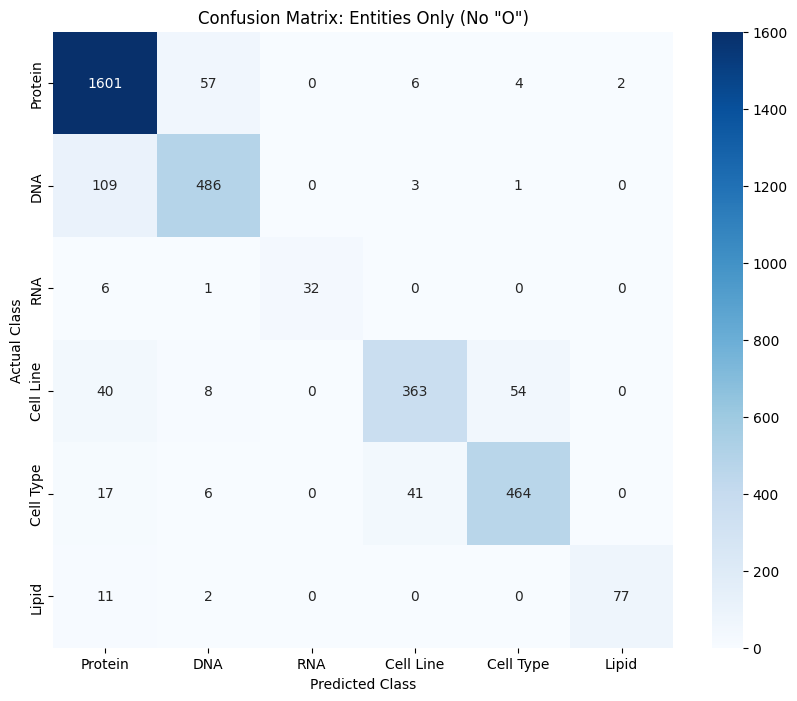

In [ ]:
# Define labels WITHOUT 'O'
labels = ['Protein', 'DNA', 'RNA', 'Cell Line', 'Cell Type', 'Lipid']

# Compute matrix only for these labels
cm = confusion_matrix(simple_true, simple_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Entities Only (No "O")')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
def test_prediction(model, vectorizer, sentence, use_viterbi=False, viterbi_decoder=None):
    """
    Test model predictions on a custom sentence.
    Simplifies 'O-POS' labels back to 'O' for clearer output.
    
    NEW: Can use Viterbi decoding for valid tag sequences.
    """
    print("\n" + "="*60)
    print("Testing Custom Sentence")
    if use_viterbi:
        print("Mode: Viterbi Decoding (Enforces valid BIO transitions)")
    else:
        print("Mode: Independent Classification (No sequence constraints)")
    print("="*60)
    print(f"Sentence: {sentence}")
    
    # 1. Tokenize
    tokens = nltk.word_tokenize(sentence)
    
    # Create dummy labels for feature extraction (not used for prediction)
    dummy_labeled = [(w, 'O') for w in tokens]
    
    # 2. Extract features with word cache and HMM
    word_cache_temp = WordCache()
    features = sentence_to_features(dummy_labeled, word_cache=word_cache_temp, hmm=hmm)
    
    # 3. Predict
    if use_viterbi and viterbi_decoder is not None:
        predictions = viterbi_decoder.decode(features)
    else:
        # Standard RF prediction (independent)
        X_test_custom = vectorizer.transform(features)
        predictions = model.predict(X_test_custom)
    
    # Simplify labels: convert 'O-POS' back to 'O'
    simplified_predictions = []
    for label in predictions:
        if label.startswith('O-'):
            simplified_predictions.append('O')
        else:
            simplified_predictions.append(label)
    
    # Print results
    print(f"\n{'Word':<20} {'Predicted Label':<20} {'Simplified'}")
    print("-" * 60)
    for word, raw_label, simple_label in zip(tokens, predictions, simplified_predictions):
        print(f"{word:<20} {raw_label:<20} {simple_label}")
    
    # Extract entities
    entities = []
    current_entity = []
    current_type = None
    
    for word, label in zip(tokens, simplified_predictions):
        if label.startswith('B-'):
            # Save previous entity if exists
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            # Start new entity
            current_entity = [word]
            current_type = label[2:]
        elif label.startswith('I-') and current_entity:
            # Continue current entity
            current_entity.append(word)
        else:
            # End of entity
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            current_entity = []
            current_type = None
    
    # Save last entity if exists
    if current_entity:
        entities.append((' '.join(current_entity), current_type))
    
    # Display entities
    print("\n" + "="*60)
    if entities:
        print(f"✓ Entities Detected: {len(entities)}")
        for entity_text, entity_type in entities:
            # Simplify entity type
            simple_type = simplify_label(f"B-{entity_type}")
            print(f"  - '{entity_text}' → {simple_type}")
    else:
        print("✗ No entities detected")
    print("="*60)

# Test with sample sentences
sample_sentences = [
    "IL-2 gene expression requires reactive oxygen production by 5-lipoxygenase.",
    "The p53 protein regulates cell cycle and apoptosis in human T cells.",
    "NF-kappa B activation occurs in peripheral blood mononuclear cells."
]

print("\n" + "#"*60)
print("# COMPARISON: Standard RF vs Viterbi Decoding")
print("#"*60)

for sent in sample_sentences:
    print("\n" + "="*60)
    print("Standard Random Forest (No Viterbi)")
    print("="*60)
    test_prediction(rf, vectorizer, sent, use_viterbi=False)
    
    print("\n" + "="*60)
    print("WITH Viterbi Decoding")
    print("="*60)
    test_prediction(rf, vectorizer, sent, use_viterbi=True, viterbi_decoder=viterbi_decoder)


############################################################
# COMPARISON: Standard RF vs Viterbi Decoding
############################################################

Standard Random Forest (No Viterbi)

Testing Custom Sentence
Mode: Independent Classification (No sequence constraints)
Sentence: IL-2 gene expression requires reactive oxygen production by 5-lipoxygenase.

Word                 Predicted Label      Simplified
------------------------------------------------------------
IL-2                 B-protein_molecule   B-protein_molecule
gene                 B-other_name         B-other_name
expression           I-other_name         I-other_name
requires             O-VBZ                O
reactive             O-JJ                 O
oxygen               O-NN                 O
production           O-NN                 O
by                   O-IN                 O
5-lipoxygenase       B-protein_molecule   B-protein_molecule
.                    O-.                  O

✓ Entities D

In [ ]:
# Encode labels for XGBoost
# XGBoost requires numeric labels (0, 1, 2...) instead of strings
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Labels encoded for XGBoost")

Labels encoded for XGBoost


In [ ]:
print("Training XGBoost...")
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# Train on encoded labels
xgb_model.fit(X_train, y_train_enc)

print("Evaluating XGBoost...")
# Predict (returns numeric labels)
y_pred_xgb_enc = xgb_model.predict(X_test)
# Convert numeric labels back to original string labels
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

print(classification_report(y_test, y_pred_xgb, labels=labels_in_test))

Training XGBoost...
Evaluating XGBoost...
Evaluating XGBoost...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.26      0.21      0.23       321
     B-DNA_family_or_group       0.18      0.14      0.16        63
            B-DNA_molecule       0.12      0.12      0.12        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.43      0.18      0.25        17
            B-RNA_molecule       0.50      0.31      0.38        16
      B-amino_acid_monomer       0.38      0.32      0.35        28
                    B-atom       0.75      0.33      0.46        18
               B-body_part       0.00      0.00      0.00        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.47      0.39      0.43        38
               B-cell_line       0.54      0.43    

Training XGBoost...
Evaluating XGBoost...
Evaluating XGBoost...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.26      0.21      0.23       321
     B-DNA_family_or_group       0.18      0.14      0.16        63
            B-DNA_molecule       0.12      0.12      0.12        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.43      0.18      0.25        17
            B-RNA_molecule       0.50      0.31      0.38        16
      B-amino_acid_monomer       0.38      0.32      0.35        28
                    B-atom       0.75      0.33      0.46        18
               B-body_part       0.00      0.00      0.00        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.47      0.39      0.43        38
               B-cell_line       0.54      0.43    

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training SVM (RBF)...")
# Support Vector Machine with Radial Basis Function kernel
# Good for non-linear boundaries
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

print("Evaluating SVM...")
y_pred_svm = svm_model.predict(X_test)

print(classification_report(y_test, y_pred_svm, labels=labels_in_test))

Training SVM (RBF)...
Evaluating SVM...
Evaluating SVM...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.65      0.44      0.53       321
     B-DNA_family_or_group       0.79      0.17      0.29        63
            B-DNA_molecule       0.75      0.12      0.21        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.67      0.35      0.46        17
            B-RNA_molecule       1.00      0.50      0.67        16
      B-amino_acid_monomer       0.61      0.39      0.48        28
                    B-atom       0.78      0.39      0.52        18
               B-body_part       1.00      0.11      0.20        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.91      0.53      0.67        38
               B-cell_line       0.79      0.47      0.59

Training SVM (RBF)...
Evaluating SVM...
Evaluating SVM...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.65      0.44      0.53       321
     B-DNA_family_or_group       0.79      0.17      0.29        63
            B-DNA_molecule       0.75      0.12      0.21        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.67      0.35      0.46        17
            B-RNA_molecule       1.00      0.50      0.67        16
      B-amino_acid_monomer       0.61      0.39      0.48        28
                    B-atom       0.78      0.39      0.52        18
               B-body_part       1.00      0.11      0.20        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.91      0.53      0.67        38
               B-cell_line       0.79      0.47      0.59

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training Logistic Regression...")
# Simple linear model, often a good baseline
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_model.fit(X_train, y_train)

print("Evaluating Logistic Regression...")
y_pred_lr = lr_model.predict(X_test)

print(classification_report(y_test, y_pred_lr, labels=labels_in_test))

Training Logistic Regression...
Evaluating Logistic Regression...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.68      0.60      0.64       321
     B-DNA_family_or_group       0.50      0.30      0.38        63
            B-DNA_molecule       0.91      0.42      0.57        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.71      0.29      0.42        17
            B-RNA_molecule       0.92      0.69      0.79        16
      B-amino_acid_monomer       0.79      0.54      0.64        28
                    B-atom       0.85      0.61      0.71        18
               B-body_part       0.83      0.28      0.42        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.86      0.66      0.75        38
               B-cell_line       0.79      0.64  

Training Logistic Regression...
Evaluating Logistic Regression...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.68      0.60      0.64       321
     B-DNA_family_or_group       0.50      0.30      0.38        63
            B-DNA_molecule       0.91      0.42      0.57        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.71      0.29      0.42        17
            B-RNA_molecule       0.92      0.69      0.79        16
      B-amino_acid_monomer       0.79      0.54      0.64        28
                    B-atom       0.85      0.61      0.71        18
               B-body_part       0.83      0.28      0.42        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.86      0.66      0.75        38
               B-cell_line       0.79      0.64  

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training Decision Tree...")
# Single Decision Tree (prone to overfitting compared to Random Forest)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

print("Evaluating Decision Tree...")
y_pred_dt = dt_model.predict(X_test)

print(classification_report(y_test, y_pred_dt, labels=labels_in_test))

Training Decision Tree...
Evaluating Decision Tree...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.54      0.45      0.49       321
     B-DNA_family_or_group       0.26      0.17      0.21        63
            B-DNA_molecule       0.19      0.17      0.18        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.56      0.29      0.38        17
            B-RNA_molecule       0.62      0.31      0.42        16
      B-amino_acid_monomer       0.29      0.32      0.31        28
                    B-atom       0.50      0.28      0.36        18
               B-body_part       0.22      0.11      0.15        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.57      0.66      0.61        38
               B-cell_line       0.64      0.52      0.57    

Training Decision Tree...
Evaluating Decision Tree...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.54      0.45      0.49       321
     B-DNA_family_or_group       0.26      0.17      0.21        63
            B-DNA_molecule       0.19      0.17      0.18        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.56      0.29      0.38        17
            B-RNA_molecule       0.62      0.31      0.42        16
      B-amino_acid_monomer       0.29      0.32      0.31        28
                    B-atom       0.50      0.28      0.36        18
               B-body_part       0.22      0.11      0.15        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.57      0.66      0.61        38
               B-cell_line       0.64      0.52      0.57    

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training Linear SVM...")
# Linear Support Vector Classification
# Faster than SVC with kernels for large datasets
linear_svm = LinearSVC(random_state=42, max_iter=1000)
linear_svm.fit(X_train, y_train)

print("Evaluating Linear SVM...")
y_pred_lsvm = linear_svm.predict(X_test)

print(classification_report(y_test, y_pred_lsvm, labels=labels_in_test))

Training Linear SVM...
Evaluating Linear SVM...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.67      0.61      0.64       321
     B-DNA_family_or_group       0.37      0.35      0.36        63
            B-DNA_molecule       0.55      0.50      0.52        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.91      0.59      0.71        17
            B-RNA_molecule       0.78      0.88      0.82        16
      B-amino_acid_monomer       0.67      0.50      0.57        28
                    B-atom       0.76      0.72      0.74        18
               B-body_part       0.77      0.56      0.65        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.85      0.74      0.79        38
               B-cell_line       0.75      0.70      0.72       221

Training Linear SVM...
Evaluating Linear SVM...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.67      0.61      0.64       321
     B-DNA_family_or_group       0.37      0.35      0.36        63
            B-DNA_molecule       0.55      0.50      0.52        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.91      0.59      0.71        17
            B-RNA_molecule       0.78      0.88      0.82        16
      B-amino_acid_monomer       0.67      0.50      0.57        28
                    B-atom       0.76      0.72      0.74        18
               B-body_part       0.77      0.56      0.65        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.85      0.74      0.79        38
               B-cell_line       0.75      0.70      0.72       221

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training Naive Bayes (Multinomial)...")
# Probabilistic classifier based on Bayes' theorem
# Works well with text data (counts/frequencies)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("Evaluating Naive Bayes...")
y_pred_nb = nb_model.predict(X_test)

print(classification_report(y_test, y_pred_nb, labels=labels_in_test))

Training Naive Bayes (Multinomial)...
Evaluating Naive Bayes...
Evaluating Naive Bayes...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.73      0.29      0.42       321
     B-DNA_family_or_group       0.00      0.00      0.00        63
            B-DNA_molecule       0.00      0.00      0.00        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.00      0.00      0.00        17
            B-RNA_molecule       0.00      0.00      0.00        16
      B-amino_acid_monomer       0.00      0.00      0.00        28
                    B-atom       0.00      0.00      0.00        18
               B-body_part       0.00      0.00      0.00        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.00      0.00      0.00        38
               B-cell_lin

Training Naive Bayes (Multinomial)...
Evaluating Naive Bayes...
Evaluating Naive Bayes...
                            precision    recall  f1-score   support

                 B-DNA_N/A       0.00      0.00      0.00         4
    B-DNA_domain_or_region       0.73      0.29      0.42       321
     B-DNA_family_or_group       0.00      0.00      0.00        63
            B-DNA_molecule       0.00      0.00      0.00        24
        B-DNA_substructure       0.00      0.00      0.00         5
     B-RNA_family_or_group       0.00      0.00      0.00        17
            B-RNA_molecule       0.00      0.00      0.00        16
      B-amino_acid_monomer       0.00      0.00      0.00        28
                    B-atom       0.00      0.00      0.00        18
               B-body_part       0.00      0.00      0.00        18
            B-carbohydrate       0.00      0.00      0.00         1
          B-cell_component       0.00      0.00      0.00        38
               B-cell_lin

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
print("Training LDA...")
# Linear Discriminant Analysis
# Requires dense arrays (high memory usage with sparse text features)
try:
    # Convert sparse matrix to dense array
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()

    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train_dense, y_train)

    print("Evaluating LDA...")
    y_pred_lda = lda_model.predict(X_test_dense)
    print(classification_report(y_test, y_pred_lda, labels=labels_in_test))
except Exception as e:
    print(f"Skipping LDA due to error (likely memory or collinearity): {e}")
    y_pred_lda = None

Training LDA...
Skipping LDA due to error (likely memory or collinearity): Unable to allocate 8.86 GiB for an array with shape (23769, 50039) and data type float64
Skipping LDA due to error (likely memory or collinearity): Unable to allocate 8.86 GiB for an array with shape (23769, 50039) and data type float64


In [ ]:
print("Training QDA...")
# Quadratic Discriminant Analysis
# Also requires dense arrays
try:
    # Re-use dense arrays if available, else convert
    if 'X_train_dense' not in locals():
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()

    qda_model = QuadraticDiscriminantAnalysis()
    qda_model.fit(X_train_dense, y_train)

    print("Evaluating QDA...")
    y_pred_qda = qda_model.predict(X_test_dense)
    print(classification_report(y_test, y_pred_qda, labels=labels_in_test))
except Exception as e:
    print(f"Skipping QDA due to error: {e}")
    y_pred_qda = None

Training QDA...


Training QDA...


c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is 

Training QDA...


c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is 

Skipping QDA due to error: y has only 1 sample in class B-RNA_domain_or_region, covariance is ill defined.


c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 4 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 5 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


                 Model  Accuracy  Weighted F1  Macro F1
0        Random Forest  0.852245     0.841787  0.583226
1              XGBoost  0.798603     0.794917  0.533049
2            SVM (RBF)  0.859733     0.847894  0.561680
3           Linear SVM  0.884051     0.881977  0.685936
4  Logistic Regression  0.882073     0.877865  0.682129
5        Decision Tree  0.830704     0.826957  0.546387
6          Naive Bayes  0.808153     0.777968  0.288895


                 Model  Accuracy  Weighted F1  Macro F1
0        Random Forest  0.852245     0.841787  0.583226
1              XGBoost  0.798603     0.794917  0.533049
2            SVM (RBF)  0.859733     0.847894  0.561680
3           Linear SVM  0.884051     0.881977  0.685936
4  Logistic Regression  0.882073     0.877865  0.682129
5        Decision Tree  0.830704     0.826957  0.546387
6          Naive Bayes  0.808153     0.777968  0.288895


C:\Users\rahli\AppData\Local\Temp\ipykernel_17420\3964946188.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weighted F1', data=df_results, palette='viridis')


                 Model  Accuracy  Weighted F1  Macro F1
0        Random Forest  0.852245     0.841787  0.583226
1              XGBoost  0.798603     0.794917  0.533049
2            SVM (RBF)  0.859733     0.847894  0.561680
3           Linear SVM  0.884051     0.881977  0.685936
4  Logistic Regression  0.882073     0.877865  0.682129
5        Decision Tree  0.830704     0.826957  0.546387
6          Naive Bayes  0.808153     0.777968  0.288895


C:\Users\rahli\AppData\Local\Temp\ipykernel_17420\3964946188.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weighted F1', data=df_results, palette='viridis')


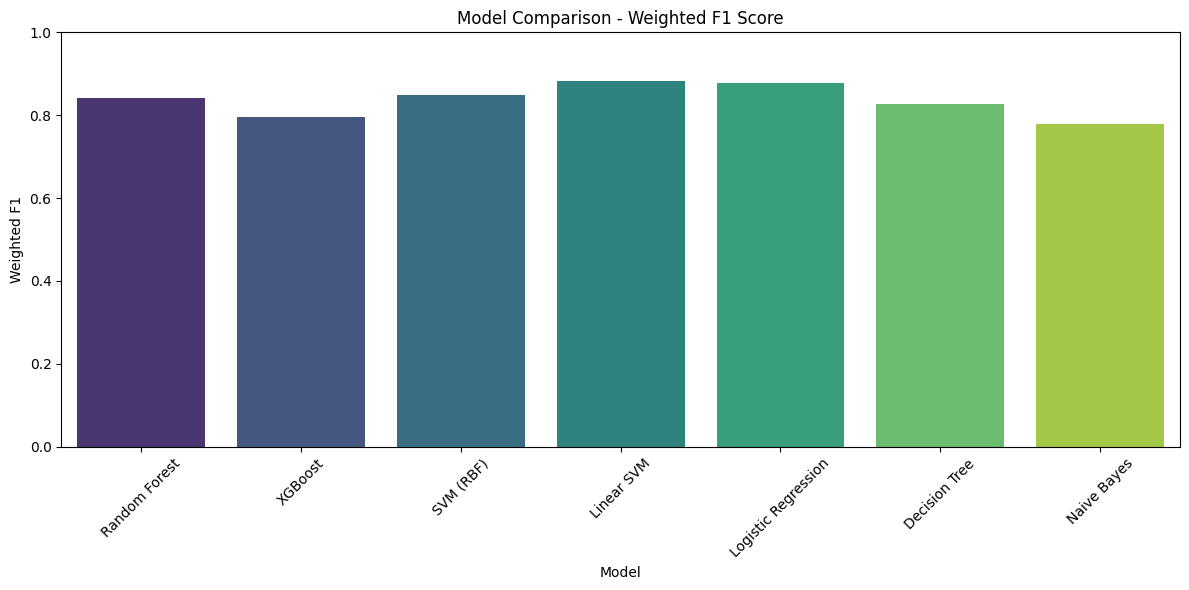

In [ ]:
# Dictionary to store predictions from all models
models = {
    'Random Forest': y_pred,
    'XGBoost': y_pred_xgb,
    'SVM (RBF)': y_pred_svm,
    'Linear SVM': y_pred_lsvm,
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Naive Bayes': y_pred_nb
}

# Add LDA/QDA only if they succeeded
if 'y_pred_lda' in locals() and y_pred_lda is not None:
    models['LDA'] = y_pred_lda
if 'y_pred_qda' in locals() and y_pred_qda is not None:
    models['QDA'] = y_pred_qda

# Calculate metrics for each model
results = []
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    f1_w = f1_score(y_test, preds, average='weighted')
    f1_m = f1_score(y_test, preds, average='macro')
    results.append({'Model': name, 'Accuracy': acc, 'Weighted F1': f1_w, 'Macro F1': f1_m})

# Create DataFrame for comparison
df_results = pd.DataFrame(results)
print(df_results)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Weighted F1', data=df_results, palette='viridis')
plt.title('Model Comparison - Weighted F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
  import joblib
import os

# Create a directory to organize saved models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

print(f"Saving artifacts to '{save_dir}/'...")

# 1. Save the Trained Models
joblib.dump(rf, os.path.join(save_dir, 'random_forest.joblib'))
joblib.dump(xgb_model, os.path.join(save_dir, 'xgboost.joblib'))
joblib.dump(svm_model, os.path.join(save_dir, 'svm.joblib'))
joblib.dump(lr_model, os.path.join(save_dir, 'logistic_regression.joblib'))
joblib.dump(dt_model, os.path.join(save_dir, 'decision_tree.joblib'))

# Save new models
joblib.dump(linear_svm, os.path.join(save_dir, 'linear_svm.joblib'))
joblib.dump(nb_model, os.path.join(save_dir, 'naive_bayes.joblib'))

if 'lda_model' in locals():
    joblib.dump(lda_model, os.path.join(save_dir, 'lda.joblib'))
if 'qda_model' in locals():
    joblib.dump(qda_model, os.path.join(save_dir, 'qda.joblib'))

# 2. Save Preprocessing Artifacts (Crucial for inference on new data)
# Save the DictVectorizer (converts features to sparse matrix)
joblib.dump(vectorizer, os.path.join(save_dir, 'vectorizer.joblib'))

# Save the LabelEncoder (converts numeric labels back to strings for XGBoost)
joblib.dump(le, os.path.join(save_dir, 'label_encoder.joblib'))

# Save the HMM model (contains the learned word states)
joblib.dump(hmm, os.path.join(save_dir, 'hmm_model.joblib'))

print("✓ All models and artifacts saved successfully.")

Saving artifacts to 'saved_models/'...
✓ All models and artifacts saved successfully.
✓ All models and artifacts saved successfully.
